# Crisis Impact Analysis

In this notebook, we will analyze the damage caused by the crisis in terms of:

## Key Metrics to Analyze

- **Total Orders Made** - Volume impact over time
- **Order Cancellation Rate** - Percentage of failed orders
- **Revenue Generated** - Total income from orders
- **Revenue from Cancelled Orders** - Lost opportunity cost
- **Costs of Cancelled Orders** - Operational expenses

## Time Periods

All metrics will be analyzed across:
- **Monthly breakdown** for 2025
- **Pre-Crisis vs Crisis Era** comparison

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [368]:
def load_data(table):
    df = pd.read_csv(f'rpc_18_inputs_for_participants//rpc_18_inputs_for_participants//RPC_18_Datasets//{table}.csv')
    return df

In [369]:
files = ['dim_customer','dim_delivery_partner_','dim_menu_item','dim_restaurant','fact_delivery_performance','fact_order_items','fact_orders','fact_ratings']

In [370]:
orders = load_data('fact_orders')
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N


## Data Preparation

For this analysis, we primarily need:
- **Month** - To aggregate data by time period
- **Hour** - To identify peak ordering times

In [371]:
orders['order_timestamp'] = pd.to_datetime(orders['order_timestamp'])

In [372]:
orders.info()

<class 'pandas.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             149166 non-null  str           
 1   customer_id          149166 non-null  str           
 2   restaurant_id        149166 non-null  str           
 3   delivery_partner_id  143531 non-null  str           
 4   order_timestamp      149166 non-null  datetime64[us]
 5   subtotal_amount      149166 non-null  float64       
 6   discount_amount      149166 non-null  float64       
 7   delivery_fee         149166 non-null  float64       
 8   total_amount         149166 non-null  float64       
 9   is_cod               149166 non-null  str           
 10  is_cancelled         149166 non-null  str           
dtypes: datetime64[us](1), float64(4), str(6)
memory usage: 12.5 MB


In [373]:
orders['month'] = orders['order_timestamp'].dt.month

In [374]:
orders['year'] = orders['order_timestamp'].dt.year
orders['year'].value_counts()

year
2025    149166
Name: count, dtype: int64

## Year Filtering

> **Note:** The year column contains only 2025 data, so it can be safely ignored in this analysis.

In [375]:
orders.drop(['year'],axis=1,inplace=True)

In [376]:
orders['month'].value_counts()

month
3    23543
1    23539
2    22667
5    22591
4    21466
6     9293
7     8818
9     8694
8     8555
Name: count, dtype: int64

In [377]:
orders['order_timestamp'].dt.hour.value_counts()

order_timestamp
19    22445
22    22380
20    22252
21    22161
13    19989
14    19977
12    19962
Name: count, dtype: int64

## Monthly Order Analysis

Let's examine the total orders placed in each month for 2025 and identify trends.

In [378]:
# pretty bad code this one 

# successfull_orders = orders[orders['is_cancelled'] =='N']

# failed_orders = orders[orders['is_cancelled'] !='N']



# trend_success= successfull_orders.groupby(['month'])['order_id'].count().pct_change()*100

# total_sucess = successfull_orders.groupby(['month'])['order_id'].count()

# trend_failed= failed_orders.groupby(['month'])['order_id'].count().pct_change()*100

# total_failed = failed_orders.groupby(['month'])['order_id'].count()



# orders_decline_delivered = pd.DataFrame({

#     'total_orders':total_orders,

#     'trend_overall':trend,

#     'total_sucess':total_sucess,

#     'trend_sucess':trend_success,

#     'trend_failed':trend_failed,
#     'total_failed':total_failed,
#     'pct_failed':(total_orders/total_failed)*100
#     })
# orders_decline_delivered

## Optimizing the Analysis

Refactoring the approach for cleaner, more maintainable code using grouped aggregations.

In [379]:
monthly_stats=(
    orders.groupby(['month','is_cancelled'])['order_id']
    .count()
    .unstack()
    .rename(columns={'N':'Sucessfull','Y':'Failed'})
    .rename_axis(None,axis=1)

)
monthly_stats['total_orders'] = monthly_stats['Sucessfull']+monthly_stats['Failed']
monthly_stats['order_trend'] = monthly_stats['total_orders'].pct_change()*100
monthly_stats['fail_pct'] = (monthly_stats['Failed']/monthly_stats['total_orders'])*100


monthly_stats

,Sucessfull,Failed,total_orders,order_trend,fail_pct
month,,,,,
1,22076,1463,23539,NaN,6.215217
2,21272,1395,22667,-3.704490,6.154321
3,22133,1410,23543,3.864649,5.989041
4,20210,1256,21466,-8.822155,5.851113
5,21221,1370,22591,5.240846,6.064362
6,8219,1074,9293,-58.864149,11.557086
7,7768,1050,8818,-5.111374,11.907462
8,7485,1070,8555,-2.982536,12.507306
9,7670,1024,8694,1.624781,11.778238


## Key Metrics Selection

**Critical Metrics Identified:**

| Metric | Importance | Reason |
|--------|-----------|--------|
| **Total Orders** | ⭐⭐⭐ | Core volume indicator for brand success |
| **Order Trend (MoM %)** | ⭐⭐⭐ | Growth trajectory and crisis severity |
| **Failure Percentage** | ⭐⭐⭐ | Service quality indicator |

**Redundant Metrics (Removed):**
- Individual success/failure counts (conveyed by aggregated metrics above)

In [380]:
monthly_stats_finalized = monthly_stats[['total_orders','order_trend','fail_pct']]
monthly_stats_finalized

,total_orders,order_trend,fail_pct
month,,,
1,23539,NaN,6.215217
2,22667,-3.704490,6.154321
3,23543,3.864649,5.989041
4,21466,-8.822155,5.851113
5,22591,5.240846,6.064362
6,9293,-58.864149,11.557086
7,8818,-5.111374,11.907462
8,8555,-2.982536,12.507306
9,8694,1.624781,11.778238


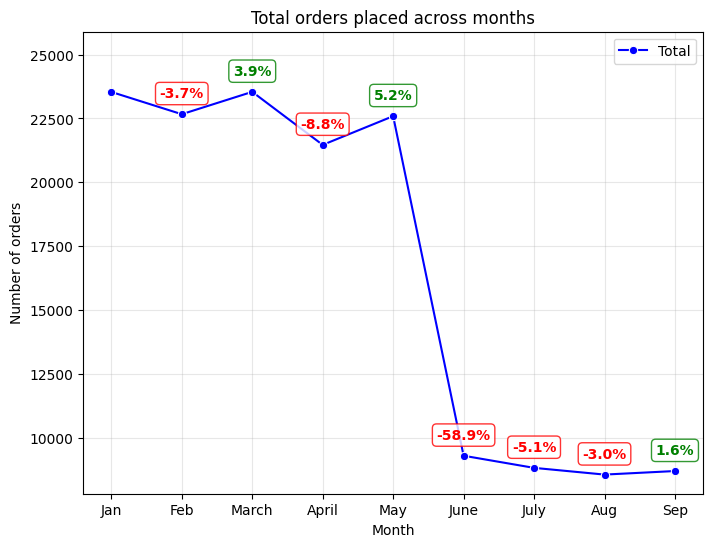

In [381]:
plt.figure(figsize=(8,6))
sns.lineplot(data= monthly_stats_finalized,x = 'month',y='total_orders',marker='o',color='b', label = 'Total')

for i,row in monthly_stats_finalized.iterrows():
    if pd.notnull(row['order_trend']):
        color_logic = 'green' if row['order_trend'] >=0 else 'red'

        plt.annotate(
            f'{row['order_trend']:.1f}%',
            xy = (i,row['total_orders']),
            xytext = (0,12),
            textcoords = 'offset points',
            color = color_logic,
            ha='center',
            fontweight='bold',
            bbox=dict(boxstyle='round', fc='white', ec=color_logic, alpha=0.8)

        )
plt.title('Total orders placed across months')
plt.xlabel('Month')
plt.xticks([1,2,3,4,5,6,7,8,9],['Jan','Feb','March','April','May','June','July','Aug','Sep'])
plt.ylabel('Number of orders')
plt.grid(alpha=0.3)
plt.ylim(top=monthly_stats_finalized['total_orders'].max()*1.1)
plt.legend()

plt.show()


In [382]:
order_per_month = pd.DataFrame({
    'Pre_crisis':monthly_stats_finalized.loc[:5,['total_orders']].mean(),
    'Crisis' :monthly_stats_finalized.loc[6:,['total_orders']].mean()
 
})
order_per_month



,Pre_crisis,Crisis
total_orders,22761.2,8840.0


C:\Users\ORACLE\AppData\Local\Temp\ipykernel_15996\4016659084.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


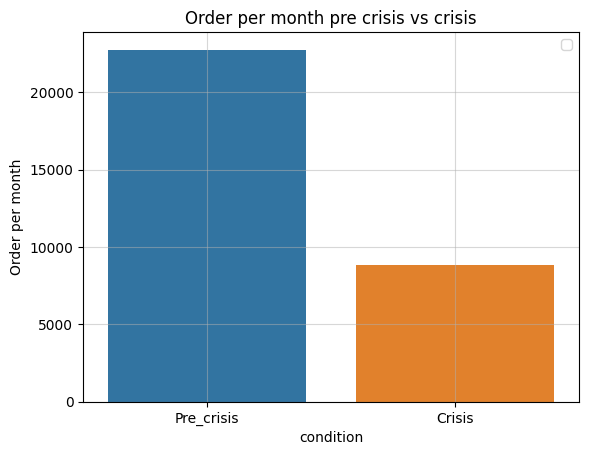

In [383]:
sns.barplot(data=order_per_month)
plt.legend()
plt.title('Order per month pre crisis vs crisis')
plt.xlabel('condition')
plt.ylabel('Order per month')
plt.grid(alpha=0.5)
plt.show()


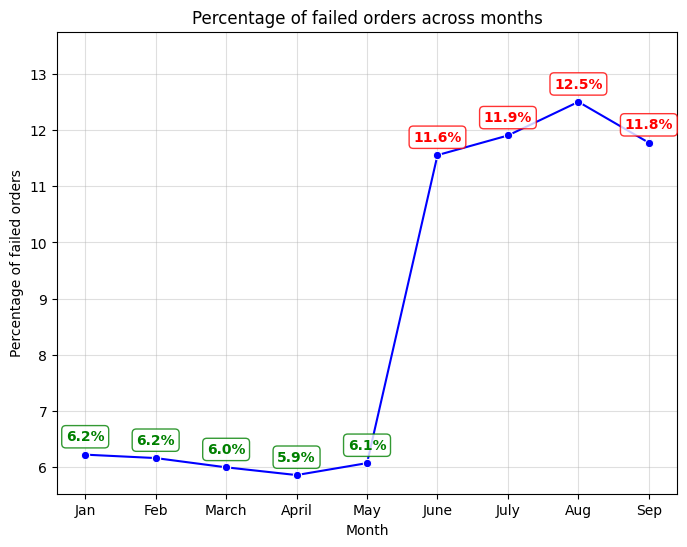

In [384]:
plt.figure(figsize=(8,6))

sns.lineplot(data=monthly_stats_finalized,x='month',y='fail_pct', marker='o', color='b')

for i,row in monthly_stats_finalized.iterrows():
    color_logic = 'green' if row['fail_pct'] <10 else 'red'
    plt.annotate(
        f'{row['fail_pct']:.1f}%',
        xy = (i,row['fail_pct']),
        xytext = (0,10),
        textcoords = 'offset points',
        ha = 'center',
        fontweight = 'bold',
        color = color_logic,
        bbox = dict(boxstyle='round',fc='white', ec = color_logic, alpha=0.8)
    )

plt.title('Percentage of failed orders across months')
plt.xticks(monthly_stats_finalized.index,['Jan','Feb','March','April','May','June','July','Aug','Sep'])

plt.xlabel('Month')
plt.ylabel('Percentage of failed orders')
plt.grid(alpha=0.4)

plt.ylim(top = monthly_stats_finalized['fail_pct'].max()*1.1)
plt.show()


In [385]:
fail_percent = pd.DataFrame({
    'Pre_crisis':monthly_stats_finalized.loc[:5,['fail_pct']].mean(),
    'Crisis' :monthly_stats_finalized.loc[6:,['fail_pct']].mean()
 
})
fail_percent



,Pre_crisis,Crisis
fail_pct,6.054811,11.937523


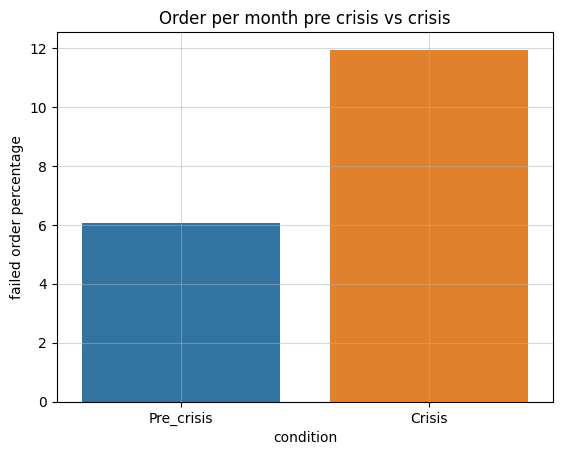

In [386]:
sns.barplot(data=fail_percent)
plt.title('Order per month pre crisis vs crisis')
plt.xlabel('condition')
plt.ylabel('failed order percentage')
plt.grid(alpha=0.5)
plt.show()


now we know how much orders and cancellation rate was impacted during crisis
lets have a look at few revenue parameters
-> revenue per month
-> revenue pre and post crisis era
-> potiential revenue lost due to low orders and cancelled orders
-> how much cod vs online payment orders were impacted

In [387]:
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [388]:
cash_flow =orders.groupby('month').agg(
    gross_amount = ('subtotal_amount','sum'),
    discount = ('discount_amount','sum'),
    delivery_fee = ('delivery_fee','sum'),
    total_amount = ('total_amount','sum')
)

In [389]:
cash_flow

,gross_amount,discount,delivery_fee,total_amount
month,,,,
1,7512822.09,455289.57,716760.77,7774293.34
2,7214790.37,435903.44,691066.05,7469953.31
3,7533281.86,449403.14,718691.44,7802568.99
4,6882073.23,413160.67,658059.94,7126972.24
5,7195624.36,436547.78,688099.54,7447176.37
6,2789338.26,168521.52,267050.00,2887866.91
7,2628719.96,156444.88,252347.56,2724623.29
8,2551068.95,152041.70,243828.90,2642856.29
9,2586074.13,150670.07,249401.72,2684804.82


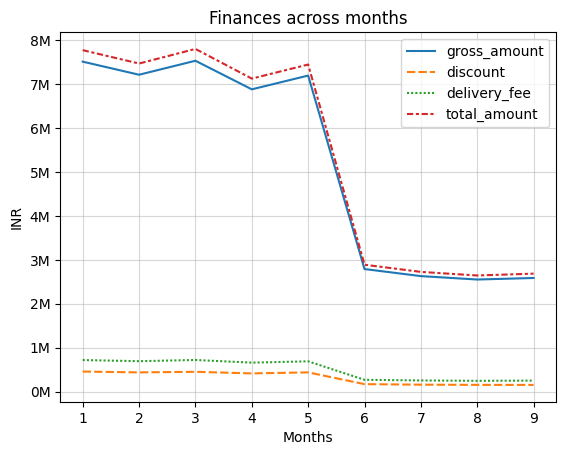

In [390]:
sns.lineplot(cash_flow)

plt.yticks(ticks=[0,1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000],labels=['0M','1M','2M','3M','4M','5M','6M','7M','8M'])
plt.title('Finances across months')
plt.xlabel('Months')
plt.ylabel('INR')
plt.grid(alpha=0.5)


so again same trend revenue went down same way as numbe of orders as expected
but this is of no use for stake holdeers lets find their pain points

In [391]:
orders.groupby(['is_cancelled','month']).agg(
    gross_amount = ('subtotal_amount','sum'),
    discount = ('discount_amount','sum'),
    delivery_fee = ('delivery_fee','sum'),
    total_amount = ('total_amount','sum')
)

gross_amount   discount  delivery_fee  total_amount
is_cancelled month                                                     
N            1        7512822.09  455289.57     716760.77    7774293.34
             2        7214790.37  435903.44     691066.05    7469953.31
             3        7533281.86  449403.14     718691.44    7802568.99
             4        6882073.23  413160.67     658059.94    7126972.24
             5        7195624.36  436547.78     688099.54    7447176.37
             6        2789338.26  168521.52     267050.00    2887866.91
             7        2628719.96  156444.88     252347.56    2724623.29
             8        2551068.95  152041.70     243828.90    2642856.29
             9        2586074.13  150670.07     249401.72    2684804.82
Y            1              0.00       0.00          0.00          0.00
             2              0.00       0.00          0.00          0.00
             3              0.00       0.00          0.00          0.00
             4              0.00       0.00          0.00          0.00
             5              0.00       0.00          0.00          0.00
             6              0.00       0.00          0.00          0.00
             7              0.00       0.00          0.00          0.00
             8              0.00       0.00          0.00          0.00
             9              0.00       0.00          0.00          0.00

ok so for cancelled orders we have no price data in this table
lets find that out and then have a look at that

In [392]:
orders[orders['is_cancelled']=='Y'].shape[0] / orders.shape[0]

0.07449418768352037

In [393]:
order_items = load_data('fact_order_items')


In [394]:
order_items.head()

,order_id,item_id,menu_item_id,restaurant_id,quantity,unit_price,item_discount,line_total
0,ORD202501006518,ITEM001,MENU12962_3216,REST12962,2,48.31,0.00,96.62
1,ORD202501006518,ITEM002,MENU12962_1962,REST12962,3,61.24,0.00,183.71
2,ORD202501019281,ITEM001,MENU14069_0510,REST14069,2,87.19,0.00,174.38
3,ORD202501019281,ITEM002,MENU14069_4308,REST14069,3,84.67,0.00,254.00
4,ORD202501023439,ITEM001,MENU08622_7574,REST08622,2,235.81,35.44,436.18


In [395]:
orders_cancelled = orders[orders['is_cancelled'] == 'Y']

In [396]:
orders_delivered = orders[orders['is_cancelled'] == 'N']

In [397]:
orders.shape

(149166, 12)

In [398]:
order_items.shape

(342994, 8)

In [399]:
order_items['order_id'].count()

np.int64(342994)

In [400]:
orders_delivered[['order_id']].merge(order_items,on='order_id',how='left')['order_id'].shape

(306646,)

In [401]:
orders_cancelled[['order_id']].merge(order_items,on='order_id',how='left')['order_id'].shape

(11112,)

In [402]:
orders['is_cancelled'].value_counts()

is_cancelled
N    138054
Y     11112
Name: count, dtype: int64

In [425]:
orders[['order_id','month']].merge(order_items,on='order_id',how='left')['quantity'].isna().sum()

np.int64(11112)

In [404]:
order_order_id = orders['order_id'].unique()
item_order_id = order_items['order_id'].unique()

In [405]:
order_order_id.shape

(149166,)

In [406]:
item_order_id.shape

(154479,)

In [407]:
problem = np.array(set(item_order_id) - set(order_order_id))

In [408]:
problem2 = np.array(set(order_order_id) - set(item_order_id))

In [409]:
problem2.ndim

0

In [427]:
menu = load_data('dim_menu_item')

In [ ]:
o

In [433]:
order_items

,order_id,item_id,menu_item_id,restaurant_id,quantity,unit_price,item_discount,line_total
0,ORD202501006518,ITEM001,MENU12962_3216,REST12962,2,48.31,0.00,96.62
1,ORD202501006518,ITEM002,MENU12962_1962,REST12962,3,61.24,0.00,183.71
2,ORD202501019281,ITEM001,MENU14069_0510,REST14069,2,87.19,0.00,174.38
3,ORD202501019281,ITEM002,MENU14069_4308,REST14069,3,84.67,0.00,254.00
4,ORD202501023439,ITEM001,MENU08622_7574,REST08622,2,235.81,35.44,436.18
...,...,...,...,...,...,...,...,...
342989,ORD202509002029,ITEM003,MENU18195_3090,REST18195,1,18.46,2.10,16.36
342990,ORD202509002029,ITEM004,MENU18195_7326,REST18195,3,25.84,8.81,68.72
342991,ORD202509007649,ITEM001,MENU04104_0153,REST04104,2,60.04,16.26,103.83
342992,ORD202509007649,ITEM002,MENU04104_5636,REST04104,1,112.24,15.20,97.04


In [434]:
menu.head()

,menu_item_id,restaurant_id,item_name,category,is_veg,price
0,MENU12962_3216,REST12962,Paneer Tikka Pizza,Pizza,Y,271.05
1,MENU12962_1962,REST12962,Pepperoni Pizza,Pizza,N,327.26
2,MENU14069_0510,REST14069,Egg Fried Rice,Fried Rice,N,200.01
3,MENU14069_4308,REST14069,Paneer Tikka,Starters,Y,198.83
4,MENU08622_7574,REST08622,Kadai Paneer,Curries,Y,271.60


In [438]:
orders_cancelled[['order_id']].merge(order_items,on='order_id',how='left')

,order_id,item_id,menu_item_id,restaurant_id,quantity,unit_price,item_discount,line_total
0,ORD202501011873,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ORD202501022002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ORD202501012168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ORD202501023485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ORD202501000523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11107,ORD202509002895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11108,ORD202509005099,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11109,ORD202509003738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11110,ORD202509003524,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [443]:
merged=orders.merge(order_items,on='order_id',how='outer')
merged[merged['is_cancelled'] =='Y']

,order_id,customer_id,restaurant_id_x,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,item_id,menu_item_id,restaurant_id_y,quantity,unit_price,item_discount,line_total
93,ORD202501000045,CUST112288,REST01270,NaN,2025-01-05 22:56:00,0.0,0.0,0.0,0.0,Y,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,ORD202501000058,CUST075187,REST19226,DP08917,2025-01-26 20:38:00,0.0,0.0,0.0,0.0,N,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,ORD202501000068,CUST153523,REST07094,NaN,2025-01-21 13:18:00,0.0,0.0,0.0,0.0,N,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,ORD202501000085,CUST186570,REST00116,NaN,2025-01-30 21:24:00,0.0,0.0,0.0,0.0,N,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,ORD202501000086,CUST130836,REST06157,DP07501,2025-01-22 19:29:00,0.0,0.0,0.0,0.0,N,Y,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353977,ORD202509010441,CUST097389,REST01848,DP13369,2025-09-25 19:30:00,0.0,0.0,0.0,0.0,N,Y,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354021,ORD202509010464,CUST141582,REST11034,DP02725,2025-09-28 13:19:00,0.0,0.0,0.0,0.0,Y,Y,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354072,ORD202509010485,CUST007332,REST06728,DP00335,2025-09-25 13:52:00,0.0,0.0,0.0,0.0,N,Y,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354096,ORD202509010495,CUST100182,REST05780,DP14127,2025-09-25 19:51:00,0.0,0.0,0.0,0.0,N,Y,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [444]:
ratings = load_data('fact_ratings')

In [446]:
orders_cancelled.merge(ratings,on='order_id',how='left')

,order_id,customer_id_x,restaurant_id_x,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,customer_id_y,restaurant_id_y,rating,review_text,review_timestamp,sentiment_score
0,ORD202501011873,CUST050526,REST19508,NaN,2025-01-01 12:10:00,0.0,0.0,0.0,0.0,N,Y,1,NaN,NaN,NaN,NaN,NaN,NaN
1,ORD202501022002,CUST114265,REST08397,NaN,2025-01-01 12:15:00,0.0,0.0,0.0,0.0,N,Y,1,NaN,NaN,NaN,NaN,NaN,NaN
2,ORD202501012168,CUST119646,REST12616,NaN,2025-01-01 12:29:00,0.0,0.0,0.0,0.0,N,Y,1,NaN,NaN,NaN,NaN,NaN,NaN
3,ORD202501023485,CUST056936,REST03176,NaN,2025-01-01 12:32:00,0.0,0.0,0.0,0.0,N,Y,1,NaN,NaN,NaN,NaN,NaN,NaN
4,ORD202501000523,CUST195834,REST10055,NaN,2025-01-01 12:33:00,0.0,0.0,0.0,0.0,N,Y,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11107,ORD202509002895,CUST169661,REST06731,DP02548,2025-09-30 22:16:00,0.0,0.0,0.0,0.0,Y,Y,9,NaN,NaN,NaN,NaN,NaN,NaN
11108,ORD202509005099,CUST040380,REST14432,NaN,2025-09-30 22:19:00,0.0,0.0,0.0,0.0,Y,Y,9,NaN,NaN,NaN,NaN,NaN,NaN
11109,ORD202509003738,CUST147227,REST05675,NaN,2025-09-30 22:38:00,0.0,0.0,0.0,0.0,Y,Y,9,NaN,NaN,NaN,NaN,NaN,NaN
11110,ORD202509003524,CUST080037,REST12269,DP13152,2025-09-30 22:51:00,0.0,0.0,0.0,0.0,N,Y,9,NaN,NaN,NaN,NaN,NaN,NaN


ok so seems like we have no infomation regarding cancelled orders in any of the tables 
so one option is to skip looking at how much damage was done but .... we need numbers to show how many business was lost

so we have two options used previous months data plane to get basic numbers on how much potiential business and cancelled orders associated money was burned 
or we can train some model which predicts the amount etc for cancelled orders and we can get params with more confidence

guess what! we will try both but in a seprate notebook to keep things clean and understandable

in this notebook we will continue to look at certain questions regarding decline

lets have a look at ratings decline and new user decline

In [ ]:
orders[['order_id','month']].merge(ratings,on='order_id',how='outer')